### CSV Inputs

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 161604 columns and 320800 nonzeros
Model fingerprint: 0x14a95873
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 160082 columns
Presolve time: 0.02s
Presolved: 400 rows, 1522 columns, 3042 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.600e+02
 Factor NZ  : 6.332e+03 (roughly 1 MB of memory)
 Factor Ops : 1.116e+05 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.04 seconds (0.04 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Ite

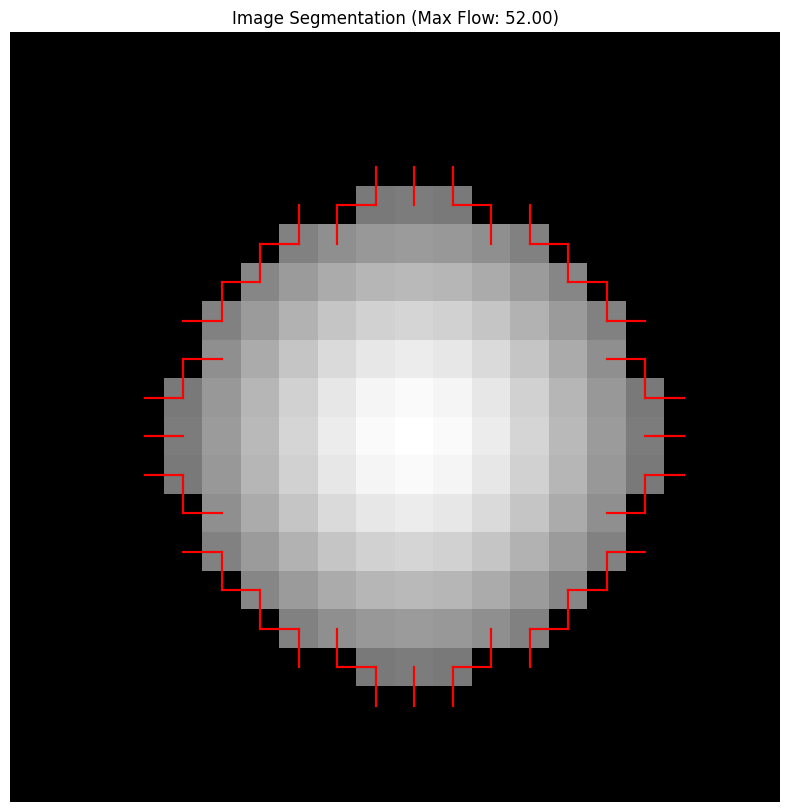

Max Flow: 52.00
Sum of cut capacities: 104.00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

# Load image data
image = pd.read_csv('oval-1.csv', header=None).values

# Parameters
sigma = 0.05
background_pixel = (0, 0)  # Backgroubd pixel
foreground_pixel = (8, 8)  # Image pixel

# Create network
def create_network(image, sigma):
    height, width = image.shape
    n = height * width
    network = np.zeros((n+2, n+2))
    
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            
            # Connect to neighbors
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor = ni * width + nj
                    similarity = 100 * np.exp(-((image[i,j] - image[ni,nj])**2) / (2 * sigma**2))
                    network[pixel, neighbor] = np.ceil(similarity)
    
    # Connect source and sink
    source, sink = n, n+1
    max_similarity = np.max(network)
    network[source, background_pixel[0]*width + background_pixel[1]] = max_similarity
    network[foreground_pixel[0]*width + foreground_pixel[1], sink] = max_similarity
    
    return network

network = create_network(image, sigma)

# Formulate and solve LP using Gurobi
n = network.shape[0]
mod = gp.Model("max_flow")

# Create variables
flow = mod.addMVar((n, n), vtype=GRB.CONTINUOUS, name="flow", lb=0, ub=network)

# Set objective: maximize flow out of source
mod.setObjective(flow[n-2, :].sum(), GRB.MAXIMIZE)

# Add flow conservation constraints
for i in range(n-2):  # for each pixel node
    mod.addConstr(flow[i, :].sum() == flow[:, i].sum())

# Optimize
mod.optimize()

# Extract solution
flow_solution = flow.X

# Find cuts
residual = network - flow_solution
G = nx.DiGraph(residual[:n-2, :n-2])
reachable = list(nx.dfs_preorder_nodes(G, source=0))
cuts = []

for i in range(n-2):
    for j in range(n-2):
        if (i in reachable) != (j in reachable):
            if network[i,j] > 0:
                cuts.append((i,j))

# Visualize results
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
for i, j in cuts:
    y1, x1 = divmod(i, image.shape[1])
    y2, x2 = divmod(j, image.shape[1])
    plt.plot([x1, x2], [y1, y2], 'r-')
plt.title(f'Image Segmentation (Max Flow: {mod.objVal:.2f})')
plt.axis('off')
plt.show()

print(f'Max Flow: {mod.objVal:.2f}')
print(f'Sum of cut capacities: {sum(network[i,j] for i,j in cuts):.2f}')

### Image

/var/folders/v1/2b2w4wyd2mv05s43hysll80m0000gn/T/ipykernel_1582/949380074.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  points = plt.ginput(2, timeout=-1)


KeyboardInterrupt: 

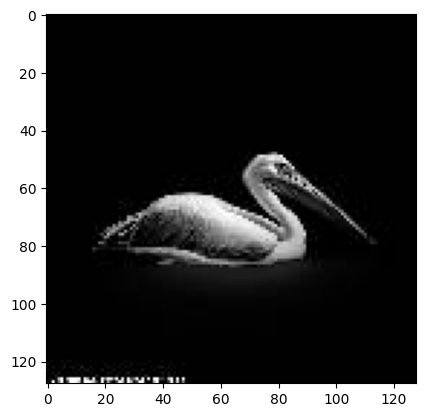

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from PIL import Image

def load_image(file_path):
    if file_path.lower().endswith('.csv'):
        return pd.read_csv(file_path, header=None).values
    elif file_path.lower().endswith('.png'):
        img = Image.open(file_path).convert('L')
        return np.array(img) / 255.0
    else:
        raise ValueError("Unsupported file format. Use CSV or PNG.")

def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    n = height * width
    network = np.zeros((n+2, n+2))
    
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor = ni * width + nj
                    similarity = 100 * np.exp(-((image[i,j] - image[ni,nj])**2) / (2 * sigma**2))
                    network[pixel, neighbor] = np.ceil(similarity)
    
    source, sink = n, n+1
    max_similarity = np.max(network)
    network[source, background_pixel[0]*width + background_pixel[1]] = max_similarity
    network[foreground_pixel[0]*width + foreground_pixel[1], sink] = max_similarity
    
    return network

def select_pixels(image):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    points = plt.ginput(2, timeout=-1)
    plt.close()
    return [(int(y), int(x)) for x, y in points]

def solve_max_flow(network):
    n = network.shape[0]
    mod = gp.Model("max_flow")
    
    flow = mod.addMVar((n, n), vtype=GRB.CONTINUOUS, name="flow", lb=0, ub=network)
    
    mod.setObjective(flow[n-2, :].sum(), GRB.MAXIMIZE)
    
    for i in range(n-2):
        mod.addConstr(flow[i, :].sum() == flow[:, i].sum())
    
    mod.optimize()
    
    return mod, flow.X

def find_cuts(network, flow_solution):
    n = network.shape[0] - 2
    residual = network[:n,:n] - flow_solution[:n,:n]
    G = nx.DiGraph(residual)
    reachable = list(nx.dfs_preorder_nodes(G, source=0))
    cuts = []
    
    for i in range(n):
        for j in range(n):
            if (i in reachable) != (j in reachable):
                if network[i,j] > 0:
                    cuts.append((i,j))
    
    return cuts

def visualize_results(image, cuts, max_flow):
    height, width = image.shape
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    for i, j in cuts:
        y1, x1 = divmod(i, width)
        y2, x2 = divmod(j, width)
        plt.plot([x1, x2], [y1, y2], 'r-')
    plt.title(f'Image Segmentation (Max Flow: {max_flow:.2f})')
    plt.axis('off')
    plt.show()

# Main execution
image_path = 'Bird.png'  # Change this to your image path
sigma = 0.05

image = load_image(image_path)
background_pixel, foreground_pixel = select_pixels(image)
network = create_network(image, sigma, background_pixel, foreground_pixel)
mod, flow_solution = solve_max_flow(network)
cuts = find_cuts(network, flow_solution)
visualize_results(image, cuts, mod.objVal)

print(f'Max Flow: {mod.objVal:.2f}')
print(f'Sum of cut capacities: {sum(network[i,j] for i,j in cuts):.2f}')

### CSV - Efficient

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 1522 columns and 3042 nonzeros
Model fingerprint: 0xca9b9574
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 2 rows and 4 columns
Presolve time: 0.00s
Presolved: 398 rows, 1518 columns, 3034 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+02   1.000000e+02   0.000000e+00      0s
     199    2.6000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 199 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.600000000e+01


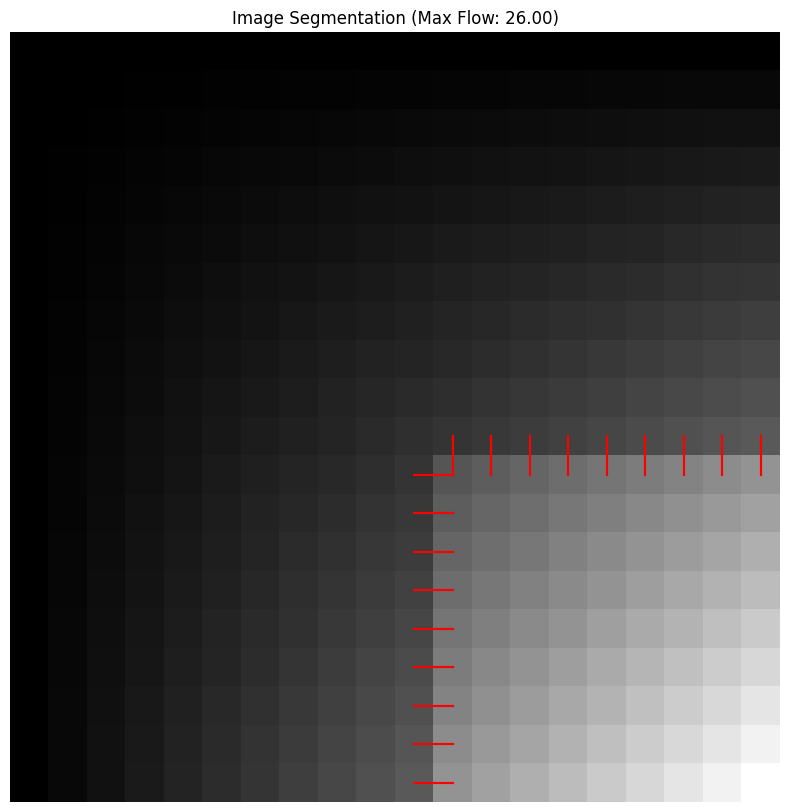

Max Flow: 26.00
Sum of cut capacities: 52.00


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

# Load image data
image = pd.read_csv('box.csv', header=None).values

# Parameters
sigma = 0.05
background_pixel = (0, 0)  # Background pixel
foreground_pixel = (19, 19)  # Foreground pixel

def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    n = height * width
    edges = []
    
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor = ni * width + nj
                    similarity = 100 * np.exp(-((image[i,j] - image[ni,nj])**2) / (2 * sigma**2))
                    if similarity > 0:
                        edges.append((pixel, neighbor, np.ceil(similarity)))
    
    source, sink = n, n+1
    max_similarity = max(edge[2] for edge in edges) if edges else 100
    
    # Connect source to background pixel and foreground pixel to sink
    bg_pixel = background_pixel[0]*width + background_pixel[1]
    fg_pixel = foreground_pixel[0]*width + foreground_pixel[1]
    edges.append((source, bg_pixel, max_similarity))
    edges.append((fg_pixel, sink, max_similarity))
    
    return edges, n+2

edges, n = create_network(image, sigma, background_pixel, foreground_pixel)

# Formulate and solve LP using Gurobi
mod = gp.Model("max_flow")

# Create variables only for existing edges
flow = mod.addVars(edges, name="flow")

# Set objective: maximize flow out of source
mod.setObjective(gp.quicksum(flow[e] for e in edges if e[0] == n-2), GRB.MAXIMIZE)

# Add flow conservation constraints
for i in range(n-2):
    mod.addConstr(
        gp.quicksum(flow[e] for e in edges if e[1] == i) ==
        gp.quicksum(flow[e] for e in edges if e[0] == i)
    )

# Set capacity constraints
for e in edges:
    flow[e].ub = e[2]

# Optimize
mod.optimize()

# Extract solution
flow_solution = {e: flow[e].X for e in edges}

# Find cuts
G = nx.DiGraph()
for e in edges:
    if e[2] - flow_solution[e] > 1e-6:  # Residual capacity
        G.add_edge(e[0], e[1])

reachable = set(nx.dfs_preorder_nodes(G, source=n-2))
cuts = [(u, v) for (u, v, _) in edges if (u in reachable) != (v in reachable)]

# Visualize results
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
for u, v in cuts:
    y1, x1 = divmod(u, image.shape[1])
    y2, x2 = divmod(v, image.shape[1])
    plt.plot([x1, x2], [y1, y2], 'r-')
plt.title(f'Image Segmentation (Max Flow: {mod.objVal:.2f})')
plt.axis('off')
plt.show()

print(f'Max Flow: {mod.objVal:.2f}')
print(f'Sum of cut capacities: {sum(e[2] for e in edges if (e[0], e[1]) in cuts):.2f}')

### Image - Efficient

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16384 rows, 65026 columns and 130050 nonzeros
Model fingerprint: 0x4c57a098
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 3 rows and 7 columns
Presolve time: 0.05s
Presolved: 16381 rows, 65019 columns, 130037 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 3.251e+04
 Factor NZ  : 4.311e+05 (roughly 36 MB of memory)
 Factor Ops : 2.462e+07 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.03175999e+01  3.392989

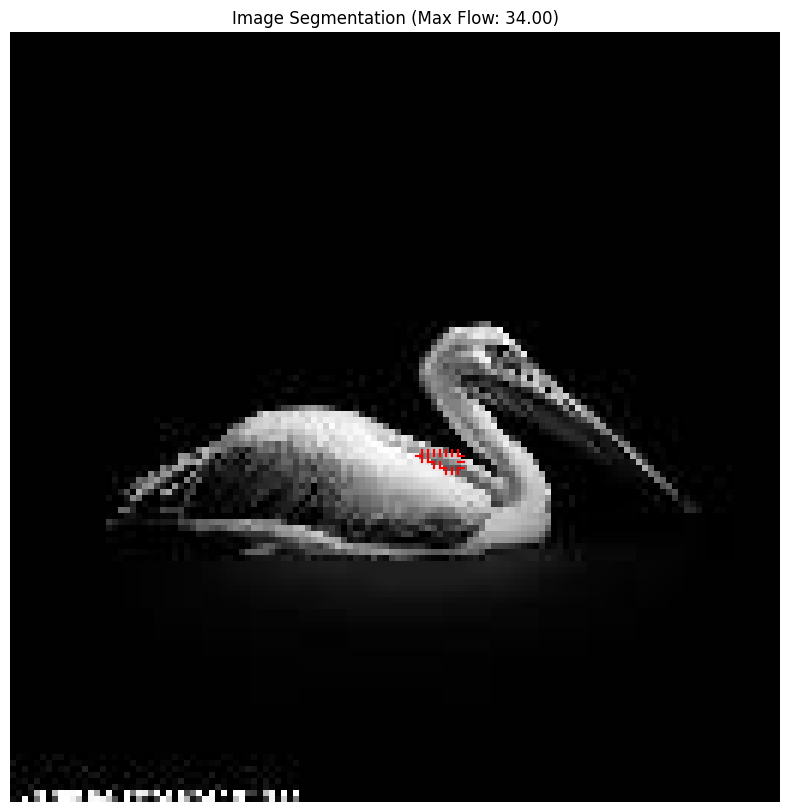

Max Flow: 34.00
Sum of cut capacities: 68.00


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from PIL import Image

def load_image(file_path):
    if file_path.lower().endswith('.csv'):
        return pd.read_csv(file_path, header=None).values
    elif file_path.lower().endswith('.png'):
        img = Image.open(file_path).convert('L')  # Convert to grayscale
        return np.array(img) / 255.0  # Normalize to [0, 1]
    else:
        raise ValueError("Unsupported file format. Use CSV or PNG.")

def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    n = height * width
    edges = []
    
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor = ni * width + nj
                    similarity = 100 * np.exp(-((image[i,j] - image[ni,nj])**2) / (2 * sigma**2))
                    edges.append((pixel, neighbor, np.ceil(similarity)))
    
    source, sink = n, n+1
    max_similarity = max(edge[2] for edge in edges) if edges else 100
    
    bg_pixel = background_pixel[0]*width + background_pixel[1]
    edges.append((source, bg_pixel, max_similarity))
    
    fg_pixel = foreground_pixel[0]*width + foreground_pixel[1]
    edges.append((fg_pixel, sink, max_similarity))
    
    return edges, n+2

def solve_max_flow(edges, n):
    mod = gp.Model("max_flow")
    
    flow = mod.addVars(edges, name="flow")
    
    mod.setObjective(gp.quicksum(flow[e] for e in edges if e[0] == n-2), GRB.MAXIMIZE)
    
    for i in range(n-2):
        mod.addConstr(
            gp.quicksum(flow[e] for e in edges if e[1] == i) ==
            gp.quicksum(flow[e] for e in edges if e[0] == i)
        )
    
    for e in edges:
        flow[e].ub = e[2]
    
    mod.optimize()
    
    return mod, {e: flow[e].X for e in edges}

def find_cuts(edges, n, flow_solution):
    G = nx.DiGraph()
    for e in edges:
        if e[2] - flow_solution[e] > 1e-6:
            G.add_edge(e[0], e[1])
    
    reachable = set(nx.dfs_preorder_nodes(G, source=n-2))
    cuts = [(u, v) for (u, v, _) in edges if (u in reachable) != (v in reachable)]
    
    return cuts

def visualize_results(image, cuts, max_flow):
    height, width = image.shape
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    for u, v in cuts:
        y1, x1 = divmod(u, width)
        y2, x2 = divmod(v, width)
        plt.plot([x1, x2], [y1, y2], 'r-')
    plt.title(f'Image Segmentation (Max Flow: {max_flow:.2f})')
    plt.axis('off')
    plt.show()

# Main execution
file_path = 'Bird.png'  # Change this to your image path (can be .csv or .png)
sigma = 0.05
background_pixel = (0, 0)  # Top-left corner
foreground_pixel = (70, 70)  # Bottom-right corner for a 20x20 image

image = load_image(file_path)
edges, n = create_network(image, sigma, background_pixel, foreground_pixel)
mod, flow_solution = solve_max_flow(edges, n)
cuts = find_cuts(edges, n, flow_solution)
visualize_results(image, cuts, mod.objVal)

print(f'Max Flow: {mod.objVal:.2f}')
print(f'Sum of cut capacities: {sum(e[2] for e in edges if (e[0], e[1]) in cuts):.2f}')

### Image Eff - Unscaled image

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16384 rows, 65026 columns and 130050 nonzeros
Model fingerprint: 0xc745c1de
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 605 rows and 2991 columns
Presolve time: 0.05s
Presolved: 15779 rows, 62035 columns, 124069 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 3.100e+04
 Factor NZ  : 3.642e+05 (roughly 34 MB of memory)
 Factor Ops : 1.445e+07 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.67341556e+01  2.5

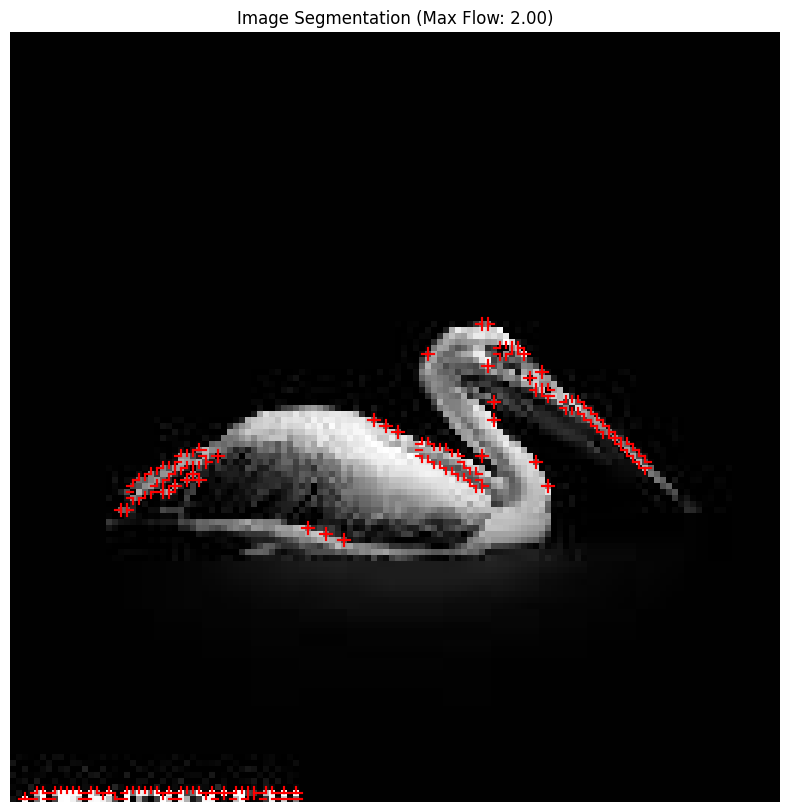

Max Flow: 2.00
Sum of cut capacities: 4.00


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from PIL import Image

def load_image(file_path):
    if file_path.lower().endswith('.csv'):
        return pd.read_csv(file_path, header=None).values
    elif file_path.lower().endswith('.png'):
        img = Image.open(file_path)
        return np.array(img) / 255.0  # Normalize to [0, 1]
    else:
        raise ValueError("Unsupported file format. Use CSV or PNG.")

def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    n = height * width
    edges = []
    
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor = ni * width + nj
                    similarity = 100 * np.exp(-((image[i,j] - image[ni,nj])**2) / (2 * sigma**2))
                    edges.append((pixel, neighbor, np.ceil(similarity)))
    
    source, sink = n, n+1
    max_similarity = max(edge[2] for edge in edges) if edges else 100
    
    bg_pixel = background_pixel[0]*width + background_pixel[1]
    edges.append((source, bg_pixel, max_similarity))
    
    fg_pixel = foreground_pixel[0]*width + foreground_pixel[1]
    edges.append((fg_pixel, sink, max_similarity))
    
    return edges, n+2

def solve_max_flow(edges, n):
    mod = gp.Model("max_flow")
    
    flow = mod.addVars(edges, name="flow")
    
    mod.setObjective(gp.quicksum(flow[e] for e in edges if e[0] == n-2), GRB.MAXIMIZE)
    
    for i in range(n-2):
        mod.addConstr(
            gp.quicksum(flow[e] for e in edges if e[1] == i) ==
            gp.quicksum(flow[e] for e in edges if e[0] == i)
        )
    
    for e in edges:
        flow[e].ub = e[2]
    
    mod.optimize()
    
    return mod, {e: flow[e].X for e in edges}

def find_cuts(edges, n, flow_solution):
    G = nx.DiGraph()
    for e in edges:
        if e[2] - flow_solution[e] > 1e-6:
            G.add_edge(e[0], e[1])
    
    reachable = set(nx.dfs_preorder_nodes(G, source=n-2))
    cuts = [(u, v) for (u, v, _) in edges if (u in reachable) != (v in reachable)]
    
    return cuts

def visualize_results(image, cuts, max_flow):
    height, width = image.shape
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    for u, v in cuts:
        y1, x1 = divmod(u, width)
        y2, x2 = divmod(v, width)
        plt.plot([x1, x2], [y1, y2], 'r-')
    plt.title(f'Image Segmentation (Max Flow: {max_flow:.2f})')
    plt.axis('off')
    plt.show()

# Main execution
file_path = 'Bird.png'  # Change this to your image path (can be .csv or .png)
sigma = 0.005
background_pixel = (0, 0)  # Top-left corner
foreground_pixel = (70, 70)  # Bottom-right corner for a 20x20 image

image = load_image(file_path)
edges, n = create_network(image, sigma, background_pixel, foreground_pixel)
mod, flow_solution = solve_max_flow(edges, n)
cuts = find_cuts(edges, n, flow_solution)
visualize_results(image, cuts, mod.objVal)

print(f'Max Flow: {mod.objVal:.2f}')
print(f'Sum of cut capacities: {sum(e[2] for e in edges if (e[0], e[1]) in cuts):.2f}')

### V3

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16384 rows, 65026 columns and 130050 nonzeros
Model fingerprint: 0x1d0fc071
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 4134 rows and 17503 columns
Presolve time: 0.05s
Presolved: 12250 rows, 47523 columns, 95045 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 2.371e+04
 Factor NZ  : 2.558e+05 (roughly 26 MB of memory)
 Factor Ops : 8.598e+06 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 0.08 seconds (0.07 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal sim

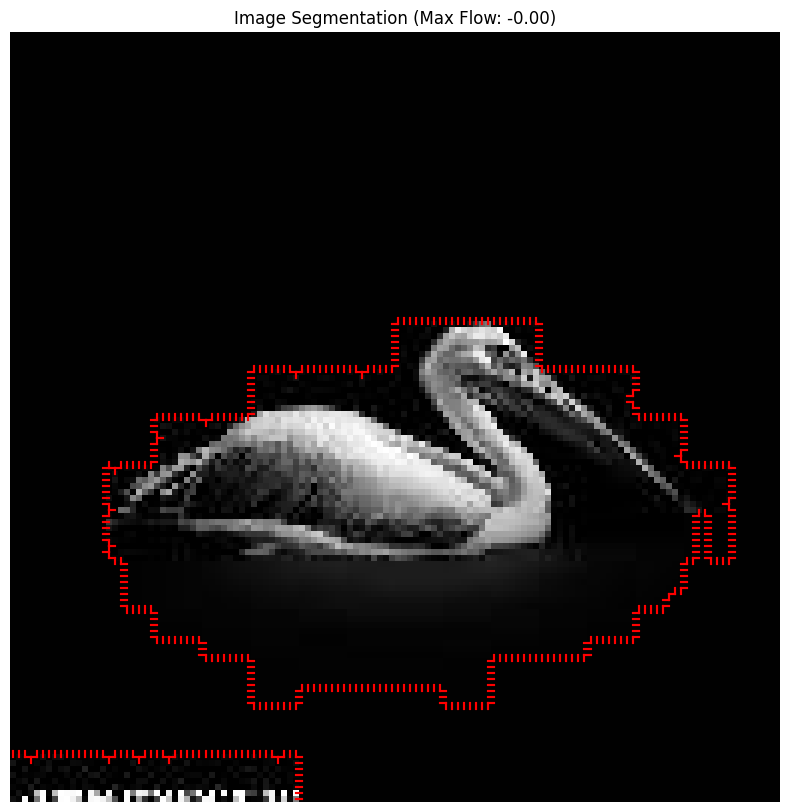

Max Flow: -0.00
Sum of cut capacities: 0.00


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from PIL import Image

def load_image(file_path):
    if file_path.lower().endswith('.csv'):
        return pd.read_csv(file_path, header=None).values
    elif file_path.lower().endswith('.png'):
        img = Image.open(file_path)
        return np.array(img) / 255.0  # Normalize to [0, 1]
    else:
        raise ValueError("Unsupported file format. Use CSV or PNG.")

def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    n = height * width
    edges = []
    
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor = ni * width + nj
                    similarity = 100 * np.exp(-((image[i,j] - image[ni,nj])**2) / (2 * sigma**2))
                    edges.append((pixel, neighbor, np.ceil(similarity)))
    
    source, sink = n, n+1
    max_similarity = max(edge[2] for edge in edges) if edges else 100
    
    bg_pixel = background_pixel[0]*width + background_pixel[1]
    edges.append((source, bg_pixel, max_similarity))
    
    fg_pixel = foreground_pixel[0]*width + foreground_pixel[1]
    edges.append((fg_pixel, sink, max_similarity))
    
    return edges, n+2

def solve_max_flow(edges, n):
    mod = gp.Model("max_flow")
    
    flow = mod.addVars(edges, name="flow")
    
    mod.setObjective(gp.quicksum(flow[e] for e in edges if e[0] == n-2), GRB.MAXIMIZE)
    
    for i in range(n-2):
        mod.addConstr(
            gp.quicksum(flow[e] for e in edges if e[1] == i) ==
            gp.quicksum(flow[e] for e in edges if e[0] == i)
        )
    
    for e in edges:
        flow[e].ub = e[2]
    
    mod.optimize()
    
    return mod, {e: flow[e].X for e in edges}

def find_cuts(edges, n, flow_solution):
    G = nx.DiGraph()
    for e in edges:
        if e[2] - flow_solution[e] > 1e-6:
            G.add_edge(e[0], e[1])
    
    reachable = set(nx.dfs_preorder_nodes(G, source=n-2))
    cuts = [(u, v) for (u, v, _) in edges if (u in reachable) != (v in reachable)]
    
    return cuts

def visualize_results(image, cuts, max_flow):
    height, width = image.shape
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    for u, v in cuts:
        y1, x1 = divmod(u, width)
        y2, x2 = divmod(v, width)
        plt.plot([x1, x2], [y1, y2], 'r-')
    plt.title(f'Image Segmentation (Max Flow: {max_flow:.2f})')
    plt.axis('off')
    plt.show()

# Main execution
file_path = 'Bird.png'  # Change this to your image path (can be .csv or .png)
sigma = 0.0001
background_pixel = (0, 0)  # Top-left corner
foreground_pixel = (70, 70)  # Bottom-right corner for a 20x20 image

image = load_image(file_path)
edges, n = create_network(image, sigma, background_pixel, foreground_pixel)
mod, flow_solution = solve_max_flow(edges, n)
cuts = find_cuts(edges, n, flow_solution)
visualize_results(image, cuts, mod.objVal)

print(f'Max Flow: {mod.objVal:.2f}')
print(f'Sum of cut capacities: {sum(e[2] for e in edges if (e[0], e[1]) in cuts):.2f}')

### V4

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16384 rows, 65026 columns and 130050 nonzeros
Model fingerprint: 0xc6198ff6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 2153 rows and 9099 columns
Presolve time: 0.05s
Presolved: 14231 rows, 55927 columns, 111853 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 2.792e+04
 Factor NZ  : 3.259e+05 (roughly 30 MB of memory)
 Factor Ops : 1.243e+07 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 0.09 seconds (0.07 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal sim

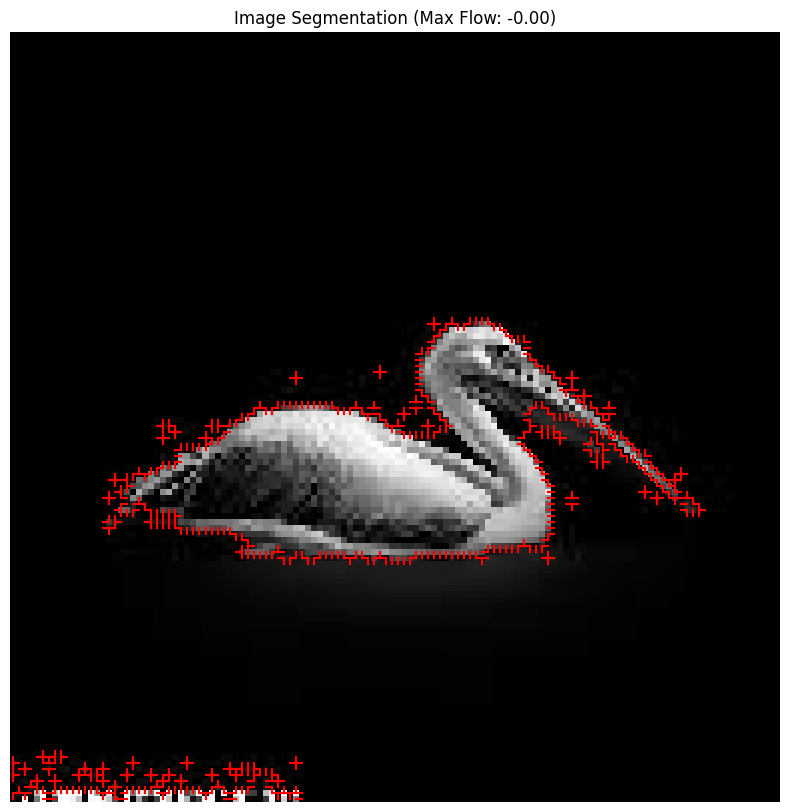

Max Flow: -0.00
Sum of cut capacities: 0.00


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from PIL import Image

def load_image(file_path):
    if file_path.lower().endswith('.csv'):
        return pd.read_csv(file_path, header=None).values
    elif file_path.lower().endswith('.png'):
        img = Image.open(file_path)
        return np.array(img) / 255.0  # Normalize to [0, 1]
    else:
        raise ValueError("Unsupported file format. Use CSV or PNG.")

def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    n = height * width
    edges = []
    
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor = ni * width + nj
                    similarity = 100 * np.exp(-((image[i,j] - image[ni,nj])**2) / (2 * sigma**2))
                    edges.append((pixel, neighbor, np.ceil(similarity)))
    
    source, sink = n, n+1
    max_similarity = max(edge[2] for edge in edges) if edges else 100
    
    bg_pixel = background_pixel[0]*width + background_pixel[1]
    edges.append((source, bg_pixel, max_similarity))
    
    fg_pixel = foreground_pixel[0]*width + foreground_pixel[1]
    edges.append((fg_pixel, sink, max_similarity))
    
    return edges, n+2

def solve_max_flow(edges, n):
    mod = gp.Model("max_flow")
    
    flow = mod.addVars(edges, name="flow")
    
    mod.setObjective(gp.quicksum(flow[e] for e in edges if e[0] == n-2), GRB.MAXIMIZE)
    
    for i in range(n-2):
        mod.addConstr(
            gp.quicksum(flow[e] for e in edges if e[1] == i) ==
            gp.quicksum(flow[e] for e in edges if e[0] == i)
        )
    
    for e in edges:
        flow[e].ub = e[2]
    
    mod.optimize()
    
    return mod, {e: flow[e].X for e in edges}

def find_cuts(edges, n, flow_solution):
    G = nx.DiGraph()
    for e in edges:
        if e[2] - flow_solution[e] > 1e-6:
            G.add_edge(e[0], e[1])
    
    reachable = set(nx.dfs_preorder_nodes(G, source=n-2))
    cuts = [(u, v) for (u, v, _) in edges if (u in reachable) != (v in reachable)]
    
    return cuts

def visualize_results(image, cuts, max_flow):
    height, width = image.shape
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    for u, v in cuts:
        y1, x1 = divmod(u, width)
        y2, x2 = divmod(v, width)
        plt.plot([x1, x2], [y1, y2], 'r-')
    plt.title(f'Image Segmentation (Max Flow: {max_flow:.2f})')
    plt.axis('off')
    plt.show()

# Main execution
file_path = 'Bird.png'  # Change this to your image path (can be .csv or .png)
sigma = 0.001
background_pixel = (0, 0)  # Top-left corner
foreground_pixel = (70, 70)  # Bottom-right corner for a 20x20 image

image = load_image(file_path)
edges, n = create_network(image, sigma, background_pixel, foreground_pixel)
mod, flow_solution = solve_max_flow(edges, n)
cuts = find_cuts(edges, n, flow_solution)
visualize_results(image, cuts, mod.objVal)

print(f'Max Flow: {mod.objVal:.2f}')
print(f'Sum of cut capacities: {sum(e[2] for e in edges if (e[0], e[1]) in cuts):.2f}')

### Considering - 8 neighbours

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16384 rows, 129542 columns and 259082 nonzeros
Model fingerprint: 0x3759a08c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 1488 rows and 15759 columns
Presolve time: 0.09s
Presolved: 14896 rows, 113783 columns, 227565 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 5.678e+04
 Factor NZ  : 5.252e+05 (roughly 60 MB of memory)
 Factor Ops : 3.181e+07 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 0.17 seconds (0.12 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal 

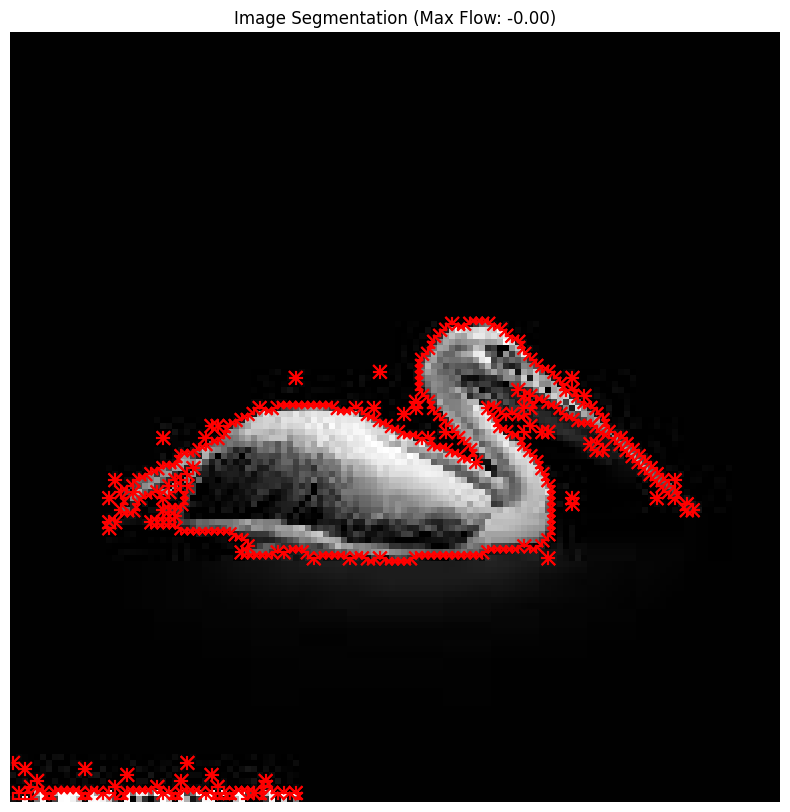

Max Flow: -0.00
Sum of cut capacities: 0.00


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from PIL import Image

def load_image(file_path):
    if file_path.lower().endswith('.csv'):
        return pd.read_csv(file_path, header=None).values
    elif file_path.lower().endswith('.png'):
        img = Image.open(file_path).convert('L')
        return np.array(img) / 255.0
    else:
        raise ValueError("Unsupported file format. Use CSV or PNG.")

def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    n = height * width
    edges = []
    
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            
            # Connect to all 8 neighbors
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor = ni * width + nj
                    similarity = 100 * np.exp(-((image[i,j] - image[ni,nj])**2) / (2 * sigma**2))
                    edges.append((pixel, neighbor, np.ceil(similarity)))
    
    source, sink = n, n+1
    max_similarity = max(edge[2] for edge in edges) if edges else 100
    
    bg_pixel = background_pixel[0]*width + background_pixel[1]
    edges.append((source, bg_pixel, max_similarity))
    
    fg_pixel = foreground_pixel[0]*width + foreground_pixel[1]
    edges.append((fg_pixel, sink, max_similarity))
    
    return edges, n+2

def solve_max_flow(edges, n):
    mod = gp.Model("max_flow")
    
    flow = mod.addVars(edges, name="flow")
    
    mod.setObjective(gp.quicksum(flow[e] for e in edges if e[0] == n-2), GRB.MAXIMIZE)
    
    for i in range(n-2):
        mod.addConstr(
            gp.quicksum(flow[e] for e in edges if e[1] == i) ==
            gp.quicksum(flow[e] for e in edges if e[0] == i)
        )
    
    for e in edges:
        flow[e].ub = e[2]
    
    mod.optimize()
    
    return mod, {e: flow[e].X for e in edges}

def find_cuts(edges, n, flow_solution):
    G = nx.DiGraph()
    for e in edges:
        if e[2] - flow_solution[e] > 1e-6:
            G.add_edge(e[0], e[1])
    
    reachable = set(nx.dfs_preorder_nodes(G, source=n-2))
    cuts = [(u, v) for (u, v, _) in edges if (u in reachable) != (v in reachable)]
    
    return cuts

def visualize_results(image, cuts, max_flow):
    height, width = image.shape
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    for u, v in cuts:
        y1, x1 = divmod(u, width)
        y2, x2 = divmod(v, width)
        plt.plot([x1, x2], [y1, y2], 'r-')
    plt.title(f'Image Segmentation (Max Flow: {max_flow:.2f})')
    plt.axis('off')
    plt.show()

# Main execution
file_path = 'Bird.png'  # Change this to your image path
sigma = 0.001
background_pixel = (0, 0)  # Adjust based on your image
foreground_pixel = (70, 70)  # Adjust based on your image

image = load_image(file_path)
edges, n = create_network(image, sigma, background_pixel, foreground_pixel)
mod, flow_solution = solve_max_flow(edges, n)
cuts = find_cuts(edges, n, flow_solution)
visualize_results(image, cuts, mod.objVal)

print(f'Max Flow: {mod.objVal:.2f}')
print(f'Sum of cut capacities: {sum(e[2] for e in edges if (e[0], e[1]) in cuts):.2f}')